In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from colour import Color
import seaborn as sn
import pandas as pd
 
 
import pingouin as pg
from scipy import stats
import random
import math
import statsmodels.api as sm 
from statsmodels.formula.api import ols

def outputIconForStats(pval):
    if pval <= 0.05:
        icon = '*'
    else:
        icon = ' '
    return icon

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}    
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)
        
    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(d_cond):
    #compare against chance
    r_data = np.random.choice([0, 1], size=len(d_cond), p=[.5, .5])
    result = pg.ttest(d_cond, r_data, correction=True) 
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True) 

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof
    
def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    
    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable] 
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):    
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")

        
def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):    
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))

# !pip install colour

def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)
        
    print("bootstraptime",BootstrapTimes,"sampletime",SampleTimes)
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))
    
    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

def ConcatData(data1, data2):
    import random
    import math
    
    #print(data1)
    #print(data2)
    if len(data1) < len(data2):        
        BootstrapTimes = len(data1)
    else:        
        BootstrapTimes = len(data2)
    
    #print(BootstrapTimes)
    y1 = random.sample(data1, BootstrapTimes)
    #print(y1)
    y2 = random.sample(data2, BootstrapTimes)
    #print(y2)
    y_comb = y1+y2
    y_comb = np.array(y_comb)        
    return y_comb

def ComputeBarStdConfMat(contents):
    modelist = ['azure', 'detectron', 'google', 'rekognition']
    print(modelist)

    #initialize matrix of absolute counts   
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    #print(result)

    # Iterating over keys
    for trialid in contents:
        trialinfor = contents[trialid]['trialData']

        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)
                
        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)
                
            modelname = trialinfor['machine_groundtruth']
            #print(modelname)
            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)
                
    #print(result)

    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']  
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    stdmodelist = ['M', 'azure', 'detectron', 'google', 'rekognition']
    modelist_stats = ['Machine', 'azure', 'detectron', 'google', 'rekognition']
    top1 = []
    top1_std = []
    #print(result_conf_mat)
    
    resultFlist = {}
    data1tot = result['result_H']
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        # compute bootstrap accuracy
        # compute and save std for top1 accuracy
        top_std_AI = boostrap(result['result_H'], result['result_' + stdmodelist[i]])
        top1_std.append(top_std_AI)
        data2tot = result['result_' + stdmodelist[i]]
        #resultFlist[modelist_stats[i]] = np.concatenate((data1tot,data2tot))
        resultFlist[modelist_stats[i]] = ConcatData(data1tot,data2tot)
        
    #print(top1)
    
    return top1, top1_std, result_conf_mat, resultFlist



with open("./savedResults/compiled.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'mturk' #choose from these choices: inlab, mturk
folderpath = './plots/Task5_' + key + '_' #for saving the plots
human_trials = CompiledResults[key]

condition_list = ['ageL35','ageG35L45','ageG45','F','M','school','bachelor','postgrad']
#,'live','sandbox']

condition_list_criteria = {'ageL35': ["18-20","21-25","26-30","31-35"], 'ageG35L45': ["36-40","41-45"], 
                           'ageG45': ["45-50","46-50"],
                           'F': ['female'],'M': ['male'], 'school': ["middle school","high school"],
                           'bachelor':['bachelor'],'postgrad': ['master','pg']}
condition_attribute = {'ageL35':'age','ageG35L45':'age','ageG45':'age',
                       'F' :'gender','M':'gender',
                       'school':'education','bachelor':'education','postgrad':'education'}


condition_numSubjs = {'ageL35':0,'ageG35L45':0,'ageG45':0,
                       'F' :0,'M':0,
                       'school':0,'bachelor':0,'postgrad':0}
condition_results = {'ageL35':{},'ageG35L45':{},'ageG45':{},
                       'F' :{},'M':{},
                       'school':{},'bachelor':{},'postgrad':{}}

for condition_chosen in condition_list:
    for trial, dat in human_trials.items():
        if dat['workerData'][condition_attribute[condition_chosen]] in condition_list_criteria[condition_chosen]:
            condition_numSubjs[condition_chosen] = condition_numSubjs[condition_chosen] + 1
            condition_results[condition_chosen]['Trial_'+str(condition_numSubjs[condition_chosen])] = dat

print(condition_numSubjs)


{'ageL35': 576, 'ageG35L45': 627, 'ageG45': 575, 'F': 729, 'M': 1049, 'school': 718, 'bachelor': 891, 'postgrad': 169}


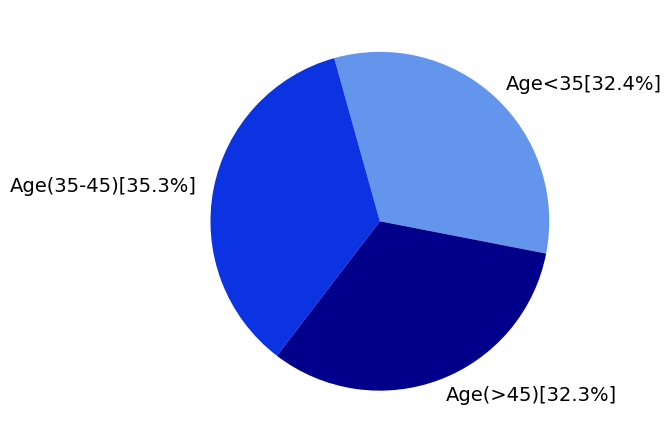

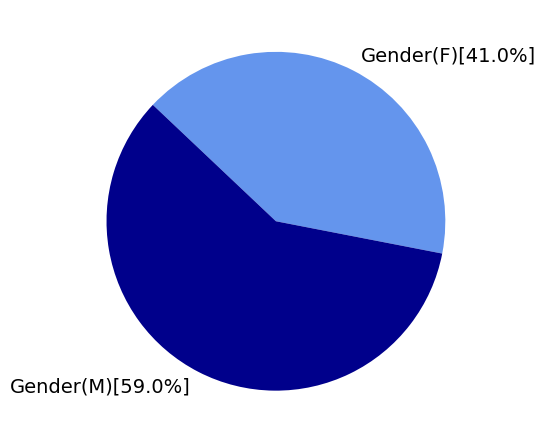

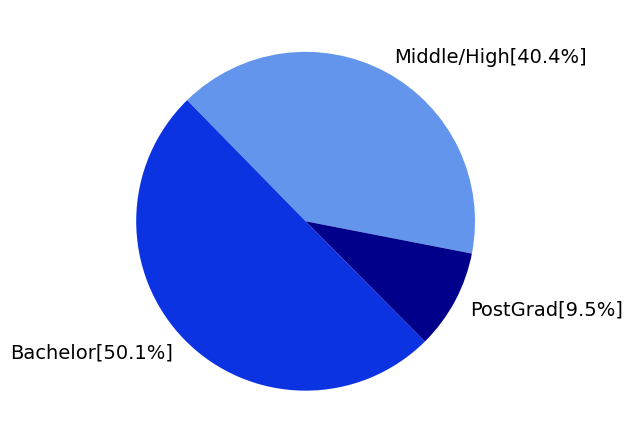

In [2]:
startColor = Color('#6495ED') #light blue
EndColor = Color("#00008B") #dark blue

#data: a list containing counts of each bin
#labels: for each data bin
#startcolor: fixed; do NOT change, always start from light blue
#endcolor: fixed; do NOT change, always end with dark blue
def plot_PieCharts(data, labels, startcolor, endcolor, folderpath, demoinfor):
    
    #label must have same lengths as data
    #normalize the list of data so that sum is 1
    datanorm = [float(i)/sum(data) for i in data]
    labels_actual = []
    for i, item in enumerate(datanorm):
        labels_actual.append( labels[i]+ "[" + str("{:.1f}".format(item*100)) + "%]" )
    
    colors = list(startColor.range_to(EndColor,len(datanorm)))
    colorlist = []
    for item in colors:
        colorlist.append(item.hex)
    #print(colorlist)
    plt.figure(figsize=(8, 5.5))
    plt.pie(datanorm, labels = labels_actual, colors = colorlist, startangle = -11, textprops={'fontsize': 14})
    plt.savefig(folderpath + demoinfor + '_DemorDistri.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + demoinfor + '_DemorDistri.png', bbox_inches='tight')
    plt.show() 


agelist = np.array([condition_numSubjs['ageL35'],
                    condition_numSubjs['ageG35L45'],
                    condition_numSubjs['ageG45']]) #number of counts within a bin
mylabels = ["Age<35","Age(35-45)","Age(>45)"]
demoinfor = 'age'
plot_PieCharts(agelist, mylabels, startColor, EndColor, folderpath, demoinfor)
    
agelist = np.array([condition_numSubjs['F'],condition_numSubjs['M']]) #number of counts within a bin
mylabels = ["Gender(F)",'Gender(M)']
demoinfor = 'gender'
plot_PieCharts(agelist, mylabels, startColor, EndColor, folderpath, demoinfor)
    
agelist = np.array([condition_numSubjs['school'],
                    condition_numSubjs['bachelor'], 
                    condition_numSubjs['postgrad']]) #number of counts within a bin
demoinfor = 'education'
mylabels = ["Middle/High","Bachelor","PostGrad"]
plot_PieCharts(agelist, mylabels, startColor, EndColor, folderpath, demoinfor)


['azure', 'detectron', 'google', 'rekognition']
bootstraptime 288 sampletime 144
bootstraptime 79 sampletime 40
bootstraptime 62 sampletime 31
bootstraptime 63 sampletime 32
bootstraptime 84 sampletime 42
['azure', 'detectron', 'google', 'rekognition']
bootstraptime 295 sampletime 148
bootstraptime 78 sampletime 39
bootstraptime 89 sampletime 45
bootstraptime 82 sampletime 41
bootstraptime 83 sampletime 42
['azure', 'detectron', 'google', 'rekognition']
bootstraptime 279 sampletime 140
bootstraptime 85 sampletime 43
bootstraptime 75 sampletime 38
bootstraptime 54 sampletime 27
bootstraptime 82 sampletime 41


/tmp/ipykernel_263370/3922338425.py:137: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


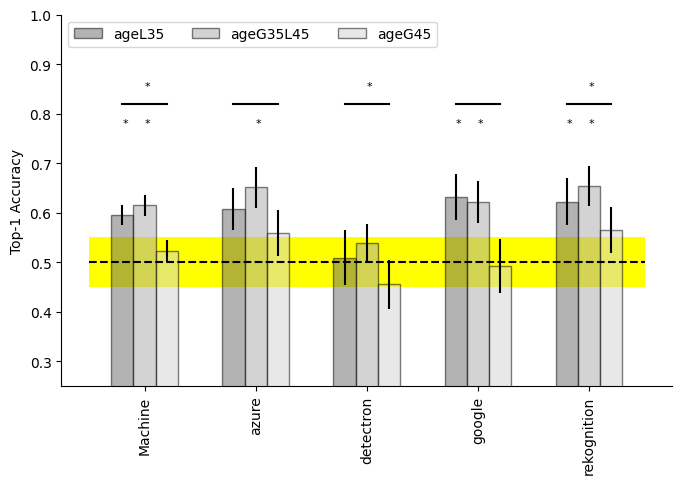

['azure', 'detectron', 'google', 'rekognition']
bootstraptime 328 sampletime 164
bootstraptime 101 sampletime 51
bootstraptime 101 sampletime 51
bootstraptime 95 sampletime 48
bootstraptime 104 sampletime 52
['azure', 'detectron', 'google', 'rekognition']
bootstraptime 515 sampletime 258
bootstraptime 141 sampletime 71
bootstraptime 125 sampletime 63
bootstraptime 104 sampletime 52
bootstraptime 145 sampletime 73


/tmp/ipykernel_263370/3922338425.py:137: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


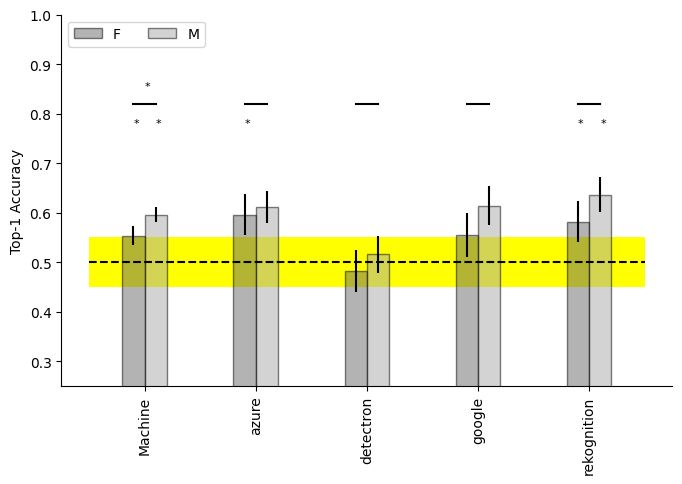

['azure', 'detectron', 'google', 'rekognition']
bootstraptime 343 sampletime 172
bootstraptime 93 sampletime 47
bootstraptime 97 sampletime 49
bootstraptime 77 sampletime 39
bootstraptime 108 sampletime 54
['azure', 'detectron', 'google', 'rekognition']
bootstraptime 437 sampletime 219
bootstraptime 124 sampletime 62
bootstraptime 108 sampletime 54
bootstraptime 101 sampletime 51
bootstraptime 121 sampletime 61
['azure', 'detectron', 'google', 'rekognition']
bootstraptime 82 sampletime 41
bootstraptime 25 sampletime 13
bootstraptime 21 sampletime 11
bootstraptime 21 sampletime 11
bootstraptime 20 sampletime 10


/tmp/ipykernel_263370/3922338425.py:137: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


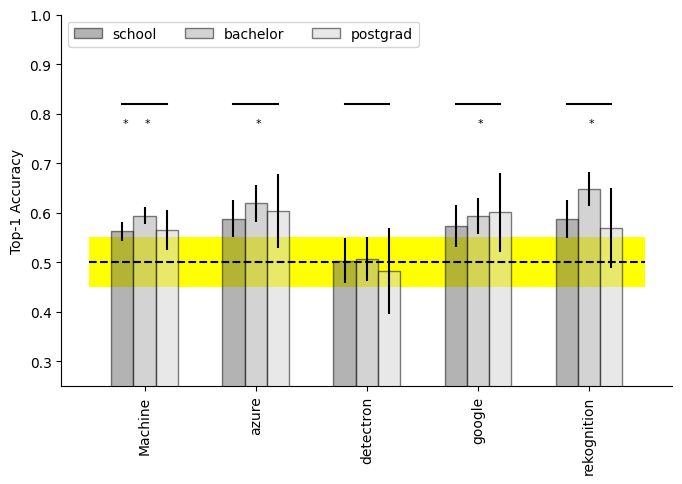

In [3]:
### plots for grouping demographic information
def plot_res_demographics(condition_chosen_list, TextFilePath, plotname,facebarcolor, condition_results):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Rectangle
    
    compiledAllConds = {}
    
    modelist = ['Machine', 'azure', 'detectron', 'google', 'rekognition']
    Pdata = {} #data stored for computing statistics 
    #initialize PData
    for i in range(0,len(modelist)):
        Pdata[modelist[i]] = {}
        
    for condition_chosen in condition_chosen_list:
        
        #print(condition_results[condition_chosen])
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(condition_results[condition_chosen])
        
        for i in range(0,len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]
            
#         #compute barplot and errorbar of barplot
#         top1 = []
#         top1std = []

#         #compute confusion matrix
#         result_conf_mat = 

        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen +'_std'] = top1std
    
    ### we have the compiled resutls now; lets calculate stats
    chancePval = []
    groupPval = []
    for i in range(0,len(modelist)):
        for condition_chosen in condition_chosen_list:        
            #compute against chance 50%
            d_cond = Pdata[modelist[i]][condition_chosen]
            icon, pval, Tval, dof = ComputeStats_group1(d_cond)
            chancePval.append(icon)
        if len(Pdata[modelist[i]].keys()) == 2:
            data_d1 = Pdata[modelist[i]][condition_chosen_list[0]]
            data_d2 = Pdata[modelist[i]][condition_chosen_list[1]]
            icon, pval, Tval, dof =  ComputeStats_group2(data_d1, data_d2)
            groupPval.append(icon)
        elif len(Pdata[modelist[i]].keys()) >= 3: 
            icon, BetweenGP_df, WithinGP_df, Fval, pval = ComputeStats_group3(Pdata[modelist[i]])
            groupPval.append(icon)
        else:
            print("Oops!  This should NOT happen...")
    
    #data
    #x-axis
    years = list(range(1, len(modelist)))
    strtask = modelist
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = [] #for plotting stats * or n.s.
    
    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5 #len(condition_chosen_list)
    else:
        multiplier = -1 #len(condition_chosen_list)
    #ngroups = len(condition_chosen_list)

    ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)    

    for ind, condition_chosen in enumerate(condition_chosen_list):
    #for condition_chosen in condition_chosen_list:
    #for attribute, measurement in compiledAllConds.items():
        measurement = compiledAllConds[condition_chosen]
        measurement_std = compiledAllConds[condition_chosen + '_std']
        attribute = condition_chosen
        
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, yerr= measurement_std, width = width,alpha=0.5,
                       label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')#,
                       #align='center', alpha=0.5, ecolor='black', capsize=10,color ='black')
        #ax.bar_label(rects, padding=3)
        point_x.extend( (x+offset).tolist() )
        multiplier += 1
    
#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    ########## ready for plotting stats
    #print(point_x)
    ###### getting statistics
    point_x.sort(reverse=False)
    #print(point_x)
    for i, p in enumerate(point_x):        
        ax.text(p, .7, chancePval[i], fontsize=8, transform=ax.get_xaxis_transform())

    ax.set_xticks(x, strtask)
    ax.legend(loc='upper left', ncols=len(condition_chosen_list))

    ###### plot stats for each group of bars
    totalPx = len(point_x)
#     print(totalPx)
#     print(point_x)
    count = 0
    for s1 in range(0,totalPx, len(condition_chosen_list)):
        center_x = 0
        for s2 in range(0,len(condition_chosen_list)):
            center_x = center_x + point_x[s1+s2]
        center_x = center_x/len(condition_chosen_list)
        starting_x = point_x[s1]
        ending_x = point_x[s1+len(condition_chosen_list)-1]
        plt.plot(   np.array([starting_x, ending_x]),
                           np.arange(2)*0+0.82, 'k', label='chance (50%)')
        ax.text(center_x, .8, groupPval[count], fontsize=8, transform=ax.get_xaxis_transform())
        count = count + 1
    
    ###### ending: plot stats for each group of bars
    
    plt.ylabel('Top-1 Accuracy')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.25, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5 
    chancex =np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(7)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.savefig(plotname + '.png',  bbox_inches='tight')
    plt.show()
#     fig.savefig('../' + plotname + '.png', bbox_inches='tight')
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.pdf', bbox_inches='tight')
    
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.png', bbox_inches='tight')


#======================AGE=======
#condition_list = ['ageL35','ageG35L45','ageG45','F','M','school','bachelor','postgrad','US','nonUS','wGenderQ','woGenderQ']
condition_chosen_list = ['ageL35','ageG35L45','ageG45']
TextFilePath = './savedResults/Task5_' + key + '_'
plotpathname = './plots/Task5_' + key + '_demor_AgeBarPlotOverall' #for saving the plots
facebarcolor = ['dimgray','darkgrey','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, condition_results)


#================================= Gender
#condition_list = ['ageL35','ageG35L45','ageG45','F','M','school','bachelor','postgrad','US','nonUS','wGenderQ','woGenderQ']
condition_chosen_list = ['F','M']
TextFilePath = './savedResults/Task5_' + key + '_'
plotpathname = './plots/Task5_' + key + '_demor_GenderBarPlotOverall' #for saving the plots
facebarcolor = ['dimgray','darkgrey','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, condition_results)

#================================= Education
#condition_list = ['ageL35','ageG35L45','ageG45','F','M','school','bachelor','postgrad','US','nonUS','wGenderQ','woGenderQ']
condition_chosen_list = ['school','bachelor','postgrad']
TextFilePath = './savedResults/Task5_' + key + '_'
plotpathname = './plots/Task5_' + key + '_demor_EducationBarPlotOverall' #for saving the plots
facebarcolor = ['dimgray','darkgrey','lightgrey']

plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, condition_results)